In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import pandas as pd
import pandas_datareader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from datetime import datetime

In [28]:
TODAY_DATE = datetime.now().strftime("%Y-%m-%d")
data_dir = Path.cwd().parent.resolve().joinpath('data')
stock_symbol = 'TSLA'

csv_path = data_dir.joinpath(f'{stock_symbol.lower()}_quote_{TODAY_DATE}.csv')
if csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    df = pandas_datareader.DataReader(name=stock_symbol,
                                      data_source='yahoo',
                                      start='2000-01-01', 
                                      end=TODAY_DATE)
    df.to_csv(csv_path)

# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/tesla-stock-price.csv')
print("Head: ", df.head())
print("Tail: ", df.tail())
df.shape

Head:           Date   High        Low       Open      Close    Volume  Adj Close
0  2010-06-29  25.00  17.540001  19.000000  23.889999  18766300  23.889999
1  2010-06-30  30.42  23.299999  25.790001  23.830000  17187100  23.830000
2  2010-07-01  25.92  20.270000  25.000000  21.959999   8218800  21.959999
3  2010-07-02  23.10  18.709999  23.000000  19.200001   5139800  19.200001
4  2010-07-06  20.00  15.830000  20.000000  16.110001   6866900  16.110001
Tail:              Date         High          Low         Open        Close   Volume  \
2541  2020-08-03  1509.810059  1444.380005  1449.199951  1485.000000  8809300   
2542  2020-08-04  1527.410034  1462.000000  1495.010010  1487.000000  8415000   
2543  2020-08-05  1499.839966  1468.310059  1492.989990  1485.020020  4978000   
2544  2020-08-06  1517.310059  1477.260010  1490.829956  1489.579956  5992300   
2545  2020-08-07  1499.750000  1415.010010  1499.540039  1452.709961  8883500   

        Adj Close  
2541  1485.000000  
2542  148

(2546, 7)

High in Blue, Low in Orange


<AxesSubplot:>

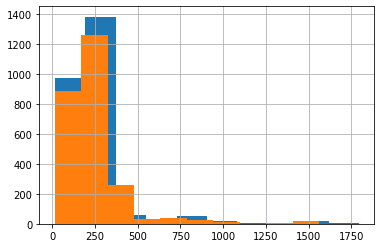

In [21]:
# understand data better

print("High in Blue, Low in Orange")
df['High'].hist()
df['Low'].hist()

In [22]:
series = df['Close'].values.reshape(-1, 1)

In [23]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [24]:
# covert to supervised learning dataset
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # convert to 3D
Y = np.array(Y)
N = len(X)
print("X.shape: ", X.shape, "Y.shape: ", Y.shape)

X.shape:  (2536, 10, 1) Y.shape:  (2536,)


In [25]:
# Build the model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.1))

# train the RNN model
r = model.fit(
    X[:-N // 2], Y[:-N // 2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
40/40 [==============================] - 1s 13ms/step - loss: 0.0351 - val_loss: 6.2748
Epoch 2/80
40/40 [==============================] - 0s 10ms/step - loss: 0.0040 - val_loss: 6.1327
Epoch 3/80
40/40 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 5.9713
Epoch 4/80
40/40 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 5.8775
Epoch 5/80
40/40 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 5.7649
Epoch 6/80
40/40 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 5.6243
Epoch 7/80
40/40 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 5.5763
Epoch 8/80
40/40 [==============================] - 0s 5ms/step - loss: 0.0028 - val_loss: 5.6284
Epoch 9/80
40/40 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 5.5729
Epoch 10/80
40/40 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 5.4693
Epoch 11/80
40/40

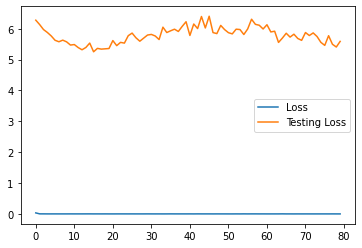

In [26]:
# Loss of model over time
plt.plot(r.history['loss'], label="Loss")
plt.plot(r.history['val_loss'], label="Testing Loss")
plt.legend()

(2536, 1)


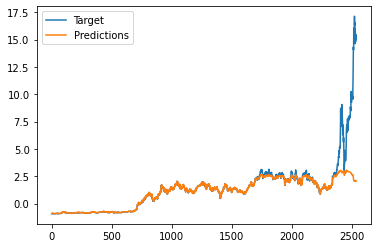

In [27]:
# Forecast/Predictions

outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label="Target")
plt.plot(predictions, label="Predictions")
plt.legend()